# Veri Yogun Uygulamalar Modul Projesi: Zaman serisi siniflandirma problemi

Dr. Ismail Guzel

Milli Teknoloji Hamlesi altinda Yapay Zeka Uzmanlık Programı kapsamında 18 saatlik Veri Yogun Uygulamar egitimi sonunda bu projenin tamamlanmasi beklenilmektedir. 

Bu proje icerisinde amac farkli sektorlerden elde dilmis zaman serileri uzerinden elde edilen faktorler uzerine kurulmus bir classification modeli kurarak benzerlik calismasi yapmaktir.

Mesela ilgilenilen bir hisse senedi X olsun, bunun bulundugu sektor bazli diger hisse senetlerin davranislarindan farkli davrandigini dusunelim. Yani sektor icinde bir artis gozlemlenirken bu hisse senetinde bir hareketlilik olmasin. Dolayisiyla, hangi sektore daha cok benziyor sorusuna cevap verebilirsek, o sektor'un hareketlerine gore bir hipotez kurabiliriz.

Bu proje, asagidaki surecleri kapsayacak:

- Sektorleriin listesine bir web-scraping ile erisilmesi ve verilerin elde edilmesi (`yfinance`, `investpy`, [`quandl`]((https://docs.data.nasdaq.com/v1.0/docs/python-installation)))
- 2005-01-01 yilindan itibaren aylik getirelerden olusan serilerin elde edilmesi
- 3 buyuk sektor uzerinden getirilerin faktorleri(momentum gibi) hesaplanmasi
- Bu momentum serileri uzerinden bir tsfresh ile feature engineering yapilmasi (imputing, encoding, transformation, ve daha fazlasi)
- Yeni elde edilmis feature ve sektor siniflari uzerinden bir model kurulmasi (en iyi model secmesi)
- Diger sektorlerden ornekler alip ayni feature engine yontemleri yaptik sonra hangi sektore benzedigine karar vermek.
- **Bonus** Mesela Real-Estate sektorunde bulunan butun sembollerin tahmini edildikten sonra cogunluk hangi sektore(T,F,H) benzedigi bilgisine erismek.

In [108]:
# %pip install yfinance
# %pip install requests
# %pip install bs4
# %pip install matplotlib
# %pip install distfit
# %pip install tsfresh
#%pip install seaborn
#%pip install tensorflow

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [17]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [50]:
def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

In [51]:
sectors=fetch_sectors_names()
indusrty=fetch_industry_names()

C:\Users\User\AppData\Local\Temp\ipykernel_37852\1494564969.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(soup.find_all("table")))[0]
C:\Users\User\AppData\Local\Temp\ipykernel_37852\1494564969.py:17: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(soup.find_all("table")))[0]


In [52]:
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1384,"9,688.02B",2.41%,14.70,17.75%,0.53%,11.62%
1,Healthcare,1216,"8,167.94B",0.43%,50.87,4.08%,1.31%,7.53%
2,Technology,788,17.72T,0.43%,44.88,13.16%,0.27%,14.87%
3,Industrials,651,"5,478.44B",1.11%,26.71,7.32%,0.55%,17.68%
4,Consumer Discretionary,577,"7,264.80B",0.65%,27.34,5.95%,0.31%,2.23%
5,Real Estate,264,"1,506.17B",4.13%,50.70,8.89%,-0.12%,6.92%
6,Materials,263,"2,069.64B",1.56%,19.61,8.68%,0.46%,2.26%
7,Communication Services,260,"5,361.25B",1.09%,28.01,10.40%,0.30%,2.10%
8,Energy,253,"3,646.14B",2.85%,8.01,12.42%,0.43%,18.22%
9,Consumer Staples,241,"4,035.49B",1.45%,29.74,4.72%,0.45%,12.15%


## Sektor listerine erismek

Yukarida yazilan fonksyionlar ile hangi sembollerin hangi sektorlerde oldugu bilgisine erisim saglanabilir ve asagidaki betikler yardimi ile `.csv` dosyalarinda saklayabiliriz. Sonrasinda, sektor bazli sembollere ait verileri indirilebilir ve siniflandirilabilir.

In [53]:
fetch_data(sectors='energy').to_csv('data/stock_sectors/energy.csv')
fetch_data(sectors='financials').to_csv('data/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('data/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('data/stock_sectors/technology.csv')
fetch_data(sectors='utilities').to_csv('data/stock_sectors/utilities.csv')
fetch_data(sectors='real-estate').to_csv('data/stock_sectors/real-estate.csv')
fetch_data(sectors='materials').to_csv('data/stock_sectors/materials.csv')
fetch_data(sectors='technology').to_csv('data/stock_sectors/technology.csv')
fetch_data(sectors='industrials').to_csv('data/stock_sectors/industrials.csv')
fetch_data(sectors='consumer-staples').to_csv('data/stock_sectors/consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv('data/stock_sectors/consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv('data/stock_sectors/communication-services.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_37852\1494564969.py:28: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(soup.find_all("table")))[0]
C:\Users\User\AppData\Local\Temp\ipykernel_37852\1494564969.py:28: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(soup.find_all("table")))[0]
C:\Users\User\AppData\Local\Temp\ipykernel_37852\1494564969.py:28: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df=pd.read_html(str(soup.find_all("table")))[0]
C:\Users\User\AppData\Local\Temp\ipykernel_37852\1494564969.py:28: FutureWarning: Passing literal html to 'read_html' is deprecated and will b

In [3]:
finance = pd.read_csv('data/stock_sectors/financials.csv')
healthcare = pd.read_csv('data/stock_sectors/healthcare.csv')
technology = pd.read_csv('data/stock_sectors/technology.csv')
finance.Symbol

0      BRK.B
1          V
2        JPM
3         MA
4        BAC
       ...  
993     NCPL
994     TIRX
995     RELI
996      DXF
997    AIMAU
Name: Symbol, Length: 998, dtype: object

In [4]:
finance.head()

,Unnamed: 0,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,0,BRK.B,Berkshire Hathaway Inc.,885.23B,0.34%,4269084,439.34B
1,1,V,Visa Inc.,581.38B,-1.18%,5096646,33.35B
2,2,JPM,JPMorgan Chase & Co.,548.13B,1.24%,9309517,158.10B
3,3,MA,Mastercard Incorporated,443.90B,-0.76%,2172459,25.10B
4,4,BAC,Bank of America Corporation,279.41B,-0.78%,39801161,98.58B


In [5]:
print(finance.info())
print(healthcare.info())
print(technology.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    998 non-null    int64 
 1   Symbol        998 non-null    object
 2   Company Name  998 non-null    object
 3   Market Cap    998 non-null    object
 4   % Change      998 non-null    object
 5   Volume        998 non-null    object
 6   Revenue       998 non-null    object
dtypes: int64(1), object(6)
memory usage: 54.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1217 non-null   int64 
 1   Symbol        1217 non-null   object
 2   Company Name  1217 non-null   object
 3   Market Cap    1217 non-null   object
 4   % Change      1217 non-null   object
 5   Volume        1217 non-null   int64 
 6   Revenue       1

In [12]:
print("technology")
technology.isna().sum()
print("healthcare")
healthcare.isna().sum()
print("finance")
finance.isna().sum()

technology


Unnamed: 0      0
Symbol          0
Company Name    0
Market Cap      0
% Change        0
Volume          0
Revenue         0
dtype: int64

healthcare


Unnamed: 0      0
Symbol          0
Company Name    0
Market Cap      0
% Change        0
Volume          0
Revenue         0
dtype: int64

finance


Unnamed: 0      0
Symbol          0
Company Name    0
Market Cap      0
% Change        0
Volume          0
Revenue         0
dtype: int64

In [11]:
#drop na in symbol
technology.dropna(subset=['Symbol'], inplace=True)
technology.isna().sum()

Unnamed: 0      0
Symbol          0
Company Name    0
Market Cap      0
% Change        0
Volume          0
Revenue         0
dtype: int64

In [23]:
technology

,Unnamed: 0,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,0,MSFT,Microsoft Corporation,"3,094.18B",-2.07%,43714326,227.58B
1,1,AAPL,Apple Inc,"2,665.58B",-0.22%,119623910,385.71B
2,2,NVDA,NVIDIA Corporation,"2,195.91B",-0.12%,63128914,60.92B
3,3,TSM,Taiwan Semiconductor Manufacturing Company Lim...,710.52B,-1.89%,17187284,70.35B
4,4,AVGO,Broadcom Inc.,572.56B,-2.12%,8834170,38.87B
...,...,...,...,...,...,...,...
782,782,SYTA,Siyata Mobile Inc.,1.69M,-0.32%,1228,8.47M
783,783,XTKG,X3 Holdings Co Ltd.,1.61M,11.64%,384380,10.05M
784,784,WISA,"WiSA Technologies, Inc.",1.60M,-7.72%,30940656,2.58M
785,785,ASTI,"Ascent Solar Technologies, Inc.",1.32M,2.65%,292284,458.26K


## Veriye erismek
Diyelim ki, finans sektorunden `HSBC` sembolu icin verileri indirmek istiyoruz. Bu adim icin `yfinance` kullanilabilir. Oncelikle `.Ticker` ile bir object olusturup onun uzerinden dogru hissemi olduguna dair bilgileri teyit edebiliriz. Sonrasinda `.get_history_metadata()` ile sembolun metedatasina erisim saglayabiliriz. Sonrasinda, `.history(period='3y')` ile 3 yillik veriyi calisma ortamimiza indirebiliriz.

In [58]:
#1 Ticker ile deneme yapıldı
ticker_name = yf.Ticker("HSBC")
ticker_name.info
ticker_name.get_history_metadata()
data=ticker_name.history(start='2005-01-01')
data.head()
data=data["Open"].resample('ME').last().pct_change()+1
data
data=pd.DataFrame(data)
data
data["id"] = "HSBC"
data
data["Sector"] = "f"
data
data.reset_index(inplace=True)
data

{'address1': '8 Canada Square',
 'city': 'London',
 'zip': 'E14 5HQ',
 'country': 'United Kingdom',
 'phone': '44 20 7991 8888',
 'fax': '44 20 7992 4880',
 'website': 'https://www.hsbc.com',
 'industry': 'Banks—Diversified',
 'sector': 'Financial Services',
 'longBusinessSummary': 'HSBC Holdings plc provides banking and financial services worldwide. The company operates through Wealth and Personal Banking, Commercial Banking, and Global Banking and Markets segments. The Wealth and Personal Banking segment offers retail banking and wealth products, including current and savings accounts, mortgages and personal loans, credit and debit cards, and local and international payment services; and wealth management services comprising insurance and investment products, global asset management services, investment management, and private wealth solutions. This segment serves personal banking and high net worth individuals. The Commercial Banking segment provides credit and lending, treasury man

In [6]:
# Extract ticker symbols from finance data
ticker_list = finance['Symbol'].tolist()

# Download stock data for the tickers starting from 2005-01-01
data = yf.download(ticker_list, start='2005-01-01') 

# Calculate monthly percentage change in opening prices
data_finance = data["Open"].resample('ME').last().pct_change() + 1

# Define a function to get rolling returns over a specified window size
def get_rolling_ret(data, n): 
    return data.rolling(n).apply(np.prod)

# Calculate 3-month rolling returns
data_finance = get_rolling_ret(data_finance, 3).fillna(0)

# Reset index and melt the data for easier analysis
data_finance = data_finance.reset_index()
data_finance = data_finance.melt(id_vars="Date", var_name="Ticker", value_name="Open")

# Fill any NaN values with 0 and add a Sector column with a default value "f"
data_finance.fillna(0, inplace=True)
data_finance["Sector"] = "f"

[*********************100%%**********************]  998 of 998 completed

8 Failed downloads:
['CRD.A', 'CRD.B', 'DYCQ', 'BNRE.A', 'LEGT', 'BRK.B', 'DISA', 'AGM.A']: Exception('%ticker%: No timezone found, symbol may be delisted')
C:\Users\User\AppData\Local\Temp\ipykernel_45432\3523440753.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_finance=data["Open"].resample('ME').last().pct_change()+1


Ticker,AACI,AACT,AAMC,AAME,AB,ABCB,ABL,ABTS,AC,ACAB,...,WU,WULF,XFIN,XP,XYF,YOTA,YRD,ZEO,ZION,ZLS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,NaN,NaN,NaN,1.006645,1.069536,1.078607,NaN,NaN,NaN,NaN,...,NaN,0.891429,NaN,NaN,NaN,NaN,NaN,NaN,0.998796,NaN
2005-03-31,NaN,NaN,NaN,1.000000,0.981152,0.951476,NaN,NaN,NaN,NaN,...,NaN,0.921474,NaN,NaN,NaN,NaN,NaN,NaN,1.034504,NaN
2005-04-30,NaN,NaN,NaN,0.990099,0.971293,1.018034,NaN,NaN,NaN,NaN,...,NaN,0.784348,NaN,NaN,NaN,NaN,NaN,NaN,1.019516,NaN
2005-05-31,NaN,NaN,NaN,1.000000,1.005778,1.018286,NaN,NaN,NaN,NaN,...,NaN,1.019956,NaN,NaN,NaN,NaN,NaN,NaN,1.018286,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,1.006579,1.007775,0.874677,1.201183,0.996522,1.155592,1.142016,1.104651,0.990828,1.000000,...,1.065514,1.088496,1.001881,1.171079,1.051852,1.001880,1.285088,1.005348,1.181183,1.004726
2023-12-31,1.005602,1.007715,1.394984,1.088670,1.086562,1.248714,1.454155,1.263158,1.060018,0.998113,...,1.018787,2.479675,1.005634,1.147826,0.856807,0.970919,1.037543,0.998227,1.256685,1.005644
2024-01-31,1.011142,1.004785,1.128090,1.194570,1.087054,0.952639,1.241379,0.875000,0.953803,1.022684,...,1.074602,0.590164,1.007470,0.962121,1.073973,1.024155,1.559210,1.012433,0.944905,1.005613


Ticker,AACI,AACT,AAMC,AAME,AB,ABCB,ABL,ABTS,AC,ACAB,...,WU,WULF,XFIN,XP,XYF,YOTA,YRD,ZEO,ZION,ZLS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-04-30,0.000000,0.000000,0.000000,0.996678,1.019253,1.044776,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.644286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.053424,0.000000
2005-05-31,0.000000,0.000000,0.000000,0.990099,0.958492,0.986347,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.737179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.073979,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,1.017094,1.013685,0.619771,1.030457,0.916507,1.065770,0.738078,0.931373,0.895455,1.008563,...,0.950487,0.544248,1.009479,0.881564,0.950893,1.010427,1.105660,1.020814,1.012828,1.013346
2023-12-31,1.006542,1.018518,1.088489,1.139175,1.012687,1.406159,1.409722,1.263158,0.972336,1.003795,...,0.884359,2.293233,1.005634,1.130137,0.890244,0.972744,1.216000,1.007156,1.286002,1.012311
2024-01-31,1.023496,1.020408,1.376452,1.562130,1.177043,1.374662,2.061518,1.220930,1.001775,1.020755,...,1.166515,1.592920,1.015052,1.293279,0.967901,0.996241,2.078947,1.016043,1.402593,1.016068


,Date,Ticker,Open
0,2005-01-31,AACI,0.000000
1,2005-02-28,AACI,0.000000
2,2005-03-31,AACI,0.000000
3,2005-04-30,AACI,0.000000
4,2005-05-31,AACI,0.000000
...,...,...,...
230533,2023-11-30,ZLS,1.013346
230534,2023-12-31,ZLS,1.012311
230535,2024-01-31,ZLS,1.016068
230536,2024-02-29,ZLS,1.011289


,Date,Ticker,Open
0,2005-01-31,AACI,0.000000
1,2005-02-28,AACI,0.000000
2,2005-03-31,AACI,0.000000
3,2005-04-30,AACI,0.000000
4,2005-05-31,AACI,0.000000
...,...,...,...
230533,2023-11-30,ZLS,1.013346
230534,2023-12-31,ZLS,1.012311
230535,2024-01-31,ZLS,1.016068
230536,2024-02-29,ZLS,1.011289


,Date,Ticker,Open,Sector
0,2005-01-31,AACI,0.000000,f
1,2005-02-28,AACI,0.000000,f
2,2005-03-31,AACI,0.000000,f
3,2005-04-30,AACI,0.000000,f
4,2005-05-31,AACI,0.000000,f
...,...,...,...,...
230533,2023-11-30,ZLS,1.013346,f
230534,2023-12-31,ZLS,1.012311,f
230535,2024-01-31,ZLS,1.016068,f
230536,2024-02-29,ZLS,1.011289,f


In [7]:
# Get ticker list from healthcare data
ticker_list = healthcare['Symbol'].tolist()

# Download data for tickers since 2005
data = yf.download(ticker_list, start='2005-01-01') 

# Calculate monthly percentage change for opening prices
data_healthcare = data["Open"].resample('ME').last().pct_change() + 1

# Define function to calculate rolling returns
def get_rolling_ret(data, n): 
    return data.rolling(n).apply(np.prod)

# Calculate 3-month rolling returns
data_healthcare = get_rolling_ret(data_healthcare, 3).fillna(0)

# Reset index and melt the data
data_healthcare = data_healthcare.reset_index()
data_healthcare = data_healthcare.melt(id_vars="Date", var_name="Ticker", value_name="Open")

# Fill missing values with 0 and add Sector column
data_healthcare.fillna(0, inplace=True)
data_healthcare["Sector"] = "h"

[*********************100%%**********************]  1217 of 1217 completed

1 Failed download:
['BIO.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-18)')
C:\Users\User\AppData\Local\Temp\ipykernel_45432\70605773.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data_healthcare=data["Open"].resample('ME').last().pct_change()+1


Ticker,A,AADI,ABBV,ABCL,ABEO,ABIO,ABOS,ABSI,ABT,ABUS,...,ZLAB,ZNTL,ZOM,ZTEK,ZTS,ZURA,ZVRA,ZVSA,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-28,1.073382,NaN,NaN,NaN,0.971223,0.959158,NaN,NaN,1.022090,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2005-03-31,0.946072,NaN,NaN,NaN,0.888889,0.841290,NaN,NaN,1.010374,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.793105
2005-04-30,0.933573,NaN,NaN,NaN,1.083333,0.944785,NaN,NaN,1.034011,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.217389
2005-05-31,1.141827,NaN,NaN,NaN,0.884615,1.240260,NaN,NaN,0.996069,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,1.242718,1.324257,0.971286,1.193548,1.307895,1.061798,1.050926,1.371901,1.104899,1.084746,...,1.109921,0.685785,1.118421,0.900763,1.111295,0.955194,1.132558,0.990099,1.293353,1.027778
2023-12-31,1.086484,0.392523,1.119774,1.237006,1.044266,0.904762,1.687225,2.879518,1.064096,1.322917,...,0.982839,1.420000,1.217647,0.872881,1.123629,1.029851,1.217659,0.282000,1.196648,1.176216
2024-01-31,0.967930,0.847619,1.072538,0.882353,0.857418,0.947368,0.856397,0.822176,1.032609,0.968504,...,0.795562,0.774008,0.652174,1.330097,0.976866,0.658385,1.000000,0.597771,1.006536,1.075368


Ticker,A,AADI,ABBV,ABCL,ABEO,ABIO,ABOS,ABSI,ABT,ABUS,...,ZLAB,ZNTL,ZOM,ZTEK,ZTS,ZURA,ZVRA,ZVSA,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-04-30,0.948040,0.000000,0.000000,0.000000,0.935252,0.762376,0.000000,0.000000,1.067815,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.965517
2005-05-31,1.008493,0.000000,0.000000,0.000000,0.851852,0.985806,0.000000,0.000000,1.040631,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.034483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,1.039721,0.798507,0.930049,0.830743,1.142529,0.921951,0.359177,0.897297,0.992633,0.955224,...,1.058668,0.414625,0.923913,0.836879,0.910434,0.688693,0.918868,0.699301,1.214383,1.193548
2023-12-31,1.229402,0.421687,1.013643,1.255274,1.287841,0.850746,0.907583,3.463768,1.121381,1.270000,...,1.128953,0.788491,1.217647,0.837398,1.120109,0.754687,1.193159,0.218605,1.702703,1.318788
2024-01-31,1.306893,0.440594,1.166514,1.302729,1.171053,0.910112,1.518518,3.247934,1.214057,1.389831,...,0.867857,0.753741,0.888158,1.045802,1.219796,0.647658,1.379070,0.166902,1.557803,1.300000


,Date,Ticker,Open
0,2005-01-31,A,0.000000
1,2005-02-28,A,0.000000
2,2005-03-31,A,0.000000
3,2005-04-30,A,0.948040
4,2005-05-31,A,1.008493
...,...,...,...
281122,2023-11-30,ZYXI,1.193548
281123,2023-12-31,ZYXI,1.318788
281124,2024-01-31,ZYXI,1.300000
281125,2024-02-29,ZYXI,1.460541


,Date,Ticker,Open
0,2005-01-31,A,0.000000
1,2005-02-28,A,0.000000
2,2005-03-31,A,0.000000
3,2005-04-30,A,0.948040
4,2005-05-31,A,1.008493
...,...,...,...
281122,2023-11-30,ZYXI,1.193548
281123,2023-12-31,ZYXI,1.318788
281124,2024-01-31,ZYXI,1.300000
281125,2024-02-29,ZYXI,1.460541


,Date,Ticker,Open,Sector
0,2005-01-31,A,0.000000,h
1,2005-02-28,A,0.000000,h
2,2005-03-31,A,0.000000,h
3,2005-04-30,A,0.948040,h
4,2005-05-31,A,1.008493,h
...,...,...,...,...
281122,2023-11-30,ZYXI,1.193548,h
281123,2023-12-31,ZYXI,1.318788,h
281124,2024-01-31,ZYXI,1.300000,h
281125,2024-02-29,ZYXI,1.460541,h


In [24]:
# Extract ticker symbols from the technology dataframe
ticker_list = technology['Symbol'].tolist()

# Download stock data for the tickers starting from 2005-01-01
data = yf.download(ticker_list, start='2005-01-01')

# Calculate monthly percentage change in opening prices
data_technology = data["Open"].resample('ME').last().pct_change() + 1

# Define a function to calculate rolling returns
def get_rolling_ret(data, n):
    return data.rolling(n).apply(np.prod)

# Calculate 3-month rolling returns
data_technology = get_rolling_ret(data_technology, 3).fillna(0)

# Reshape the data
data_technology = data_technology.reset_index()
data_technology = data_technology.melt(id_vars="Date", var_name="Ticker", value_name="Open")
data_technology

# Add a sector column with value 't'
data_technology["Sector"] = "t"

[*********************100%%**********************]  786 of 786 completed


,Date,Ticker,Open
0,2005-01-31,AAOI,0.000000
1,2005-02-28,AAOI,0.000000
2,2005-03-31,AAOI,0.000000
3,2005-04-30,AAOI,0.000000
4,2005-05-31,AAOI,0.000000
...,...,...,...
181561,2023-11-30,ZUO,1.048405
181562,2023-12-31,ZUO,1.150718
181563,2024-01-31,ZUO,1.269601
181564,2024-02-29,ZUO,0.833158


In [25]:
data_technology

,Date,Ticker,Open,Sector
0,2005-01-31,AAOI,0.000000,t
1,2005-02-28,AAOI,0.000000,t
2,2005-03-31,AAOI,0.000000,t
3,2005-04-30,AAOI,0.000000,t
4,2005-05-31,AAOI,0.000000,t
...,...,...,...,...
181561,2023-11-30,ZUO,1.048405,t
181562,2023-12-31,ZUO,1.150718,t
181563,2024-01-31,ZUO,1.269601,t
181564,2024-02-29,ZUO,0.833158,t


Simdi ise, belirlenen sembollerin verilerini belli bir tarih sonrasinda cekebiliriz. Sonrasinda aylik getirileri hesaplayabiliriz. Proje kapsaminda bu yontem kullanilacak.

In [59]:
all_data = pd.concat([data_finance, data_healthcare, data_technology])
all_data

,Date,Ticker,Open,Sector
0,2005-01-31,AACI,0.000000,f
1,2005-02-28,AACI,0.000000,f
2,2005-03-31,AACI,0.000000,f
3,2005-04-30,AACI,0.000000,f
4,2005-05-31,AACI,0.000000,f
...,...,...,...,...
181561,2023-11-30,ZUO,1.048405,t
181562,2023-12-31,ZUO,1.150718,t
181563,2024-01-31,ZUO,1.269601,t
181564,2024-02-29,ZUO,0.833158,t


In [27]:
#groupby Date where 2005-01-31
all_data.groupby('Date').get_group('2005-02-28')

,Date,Ticker,Open,Sector
1,2005-02-28,AACI,0.0,f
232,2005-02-28,AACT,0.0,f
463,2005-02-28,AAMC,0.0,f
694,2005-02-28,AAME,0.0,f
925,2005-02-28,AB,0.0,f
...,...,...,...,...
180412,2005-02-28,ZFOX,0.0,t
180643,2005-02-28,ZI,0.0,t
180874,2005-02-28,ZM,0.0,t
181105,2005-02-28,ZS,0.0,t


In [28]:
all_data.isna().sum()

Date      0
Ticker    0
Open      0
Sector    0
dtype: int64

In [29]:
#check inf
all_data.isin([np.inf, -np.inf]).sum()

Date      0
Ticker    0
Open      0
Sector    0
dtype: int64

<Figure size 1600x400 with 0 Axes>

Text(0.5, 1.0, "Open Prices for Ticker 'AAME' (Logarithmic Scale)")

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Open Price')

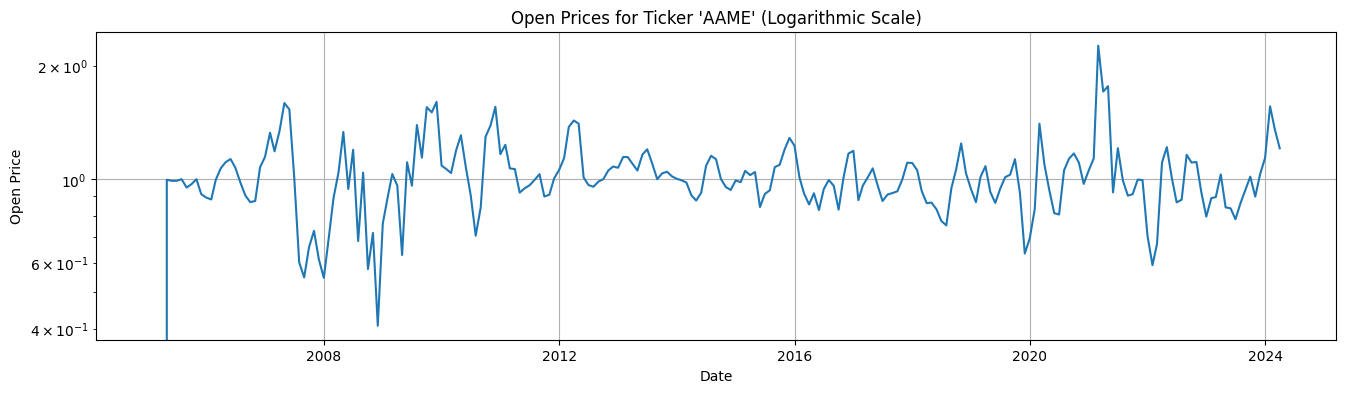

In [30]:
# Filter data for ticker 'AAME'
ticker_data = all_data[all_data['Ticker'] == 'AAME']

# Plot 'Open' prices with logarithmic scale
plt.figure(figsize=(16, 4))
plt.plot(ticker_data['Date'], ticker_data['Open'])
plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title("Open Prices for Ticker 'AAME' (Logarithmic Scale)")
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Sector'>

Text(0.5, 1.0, 'Mean Open Prices by Sector')

Text(0.5, 0, 'Sector')

Text(0, 0.5, 'Mean Open Price')

(array([0, 1, 2]), [Text(0, 0, 'f'), Text(1, 0, 'h'), Text(2, 0, 't')])

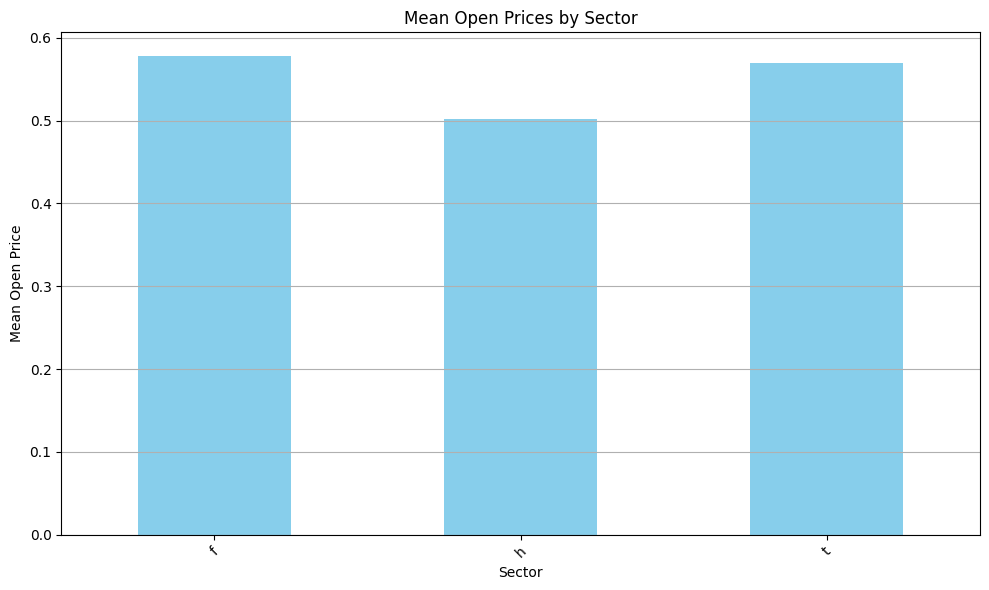

In [39]:
# Calculate mean open price for each sector
sector_means = all_data.groupby('Sector')['Open'].mean()

# Plot mean open prices for each sector
plt.figure(figsize=(10, 6))
sector_means.plot(kind='bar', color='skyblue')
plt.title('Mean Open Prices by Sector')
plt.xlabel('Sector')
plt.ylabel('Mean Open Price')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Figure size 1600x400 with 0 Axes>

Text(0.5, 1.0, 'Mean Open Prices for All Sectors (Logarithmic Scale)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Mean Open Price')

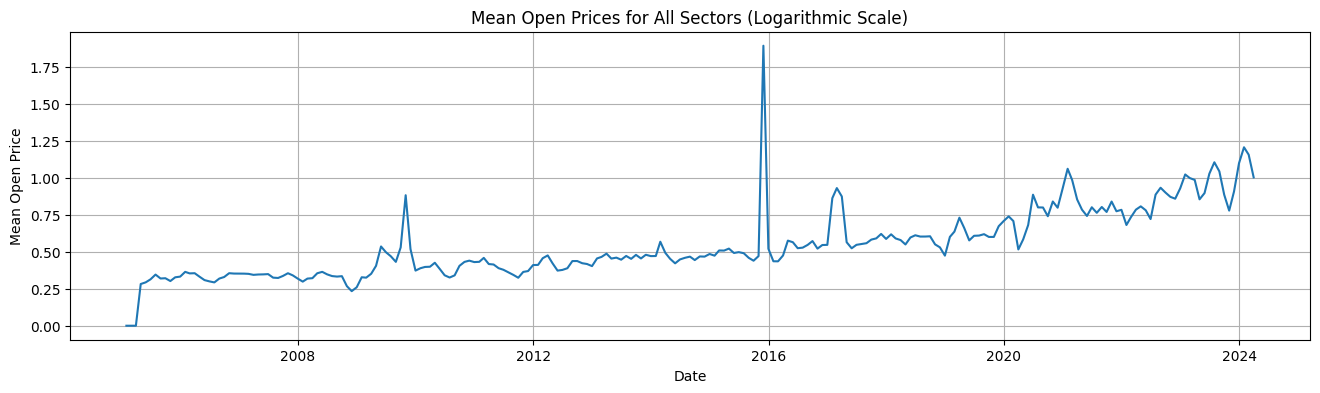

In [42]:
import matplotlib.pyplot as plt

# Calculate mean open price for all sectors
all_sectors_mean_open = all_data.groupby('Date')['Open'].mean()

# Plot mean open prices with logarithmic scale
plt.figure(figsize=(16, 4))
plt.plot(all_sectors_mean_open.index, all_sectors_mean_open.values)  # Set y-axis scale to logarithmic
plt.title("Mean Open Prices for All Sectors (Logarithmic Scale)")
plt.xlabel('Date')
plt.ylabel('Mean Open Price')
plt.grid(True)
plt.show()


<Figure size 1600x800 with 0 Axes>

Text(0.5, 1.0, 'Mean Open Prices for Each Sector ')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Mean Open Price')

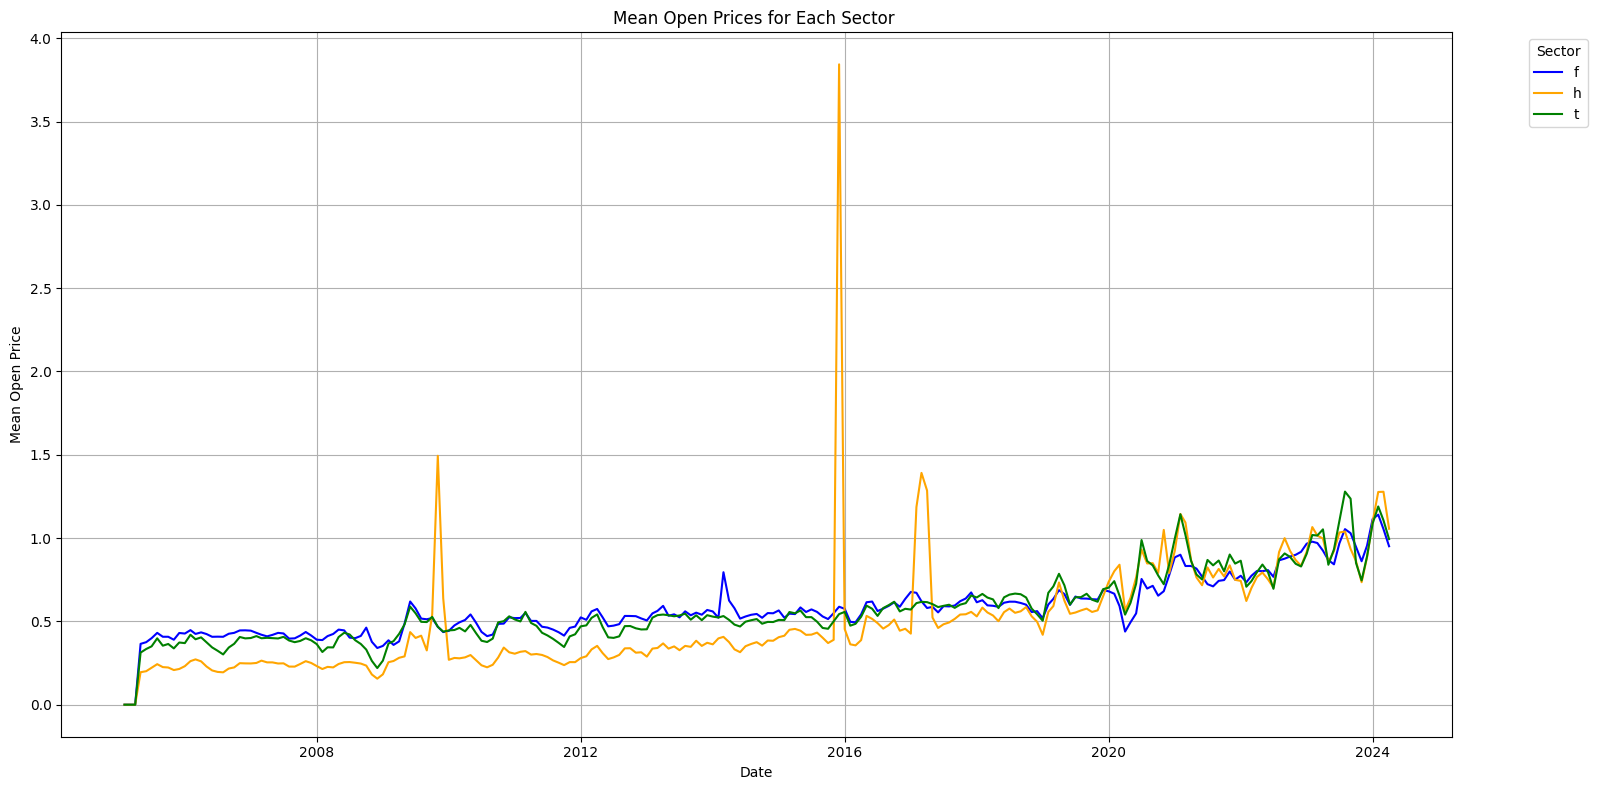

In [47]:
# Group data by sector
sector_groups = all_data.groupby('Sector')

# Define colors for each sector
colors = ['blue', 'orange', 'green']  # You can extend this list as needed

# Plot 'Open' prices for each sector with logarithmic scale
plt.figure(figsize=(16, 8))

for i, (sector, data) in enumerate(sector_groups):
    mean_open_prices = data.groupby('Date')['Open'].mean()
    plt.plot(mean_open_prices.index, mean_open_prices.values, label=sector, color=colors[i])

plt.title("Mean Open Prices for Each Sector ")
plt.xlabel('Date')
plt.ylabel('Mean Open Price')
plt.grid(True)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1600x800 with 0 Axes>

Text(0.5, 1.0, 'Mean Open Prices for Each Sector (Logarithmic Scale)')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Mean Open Price')

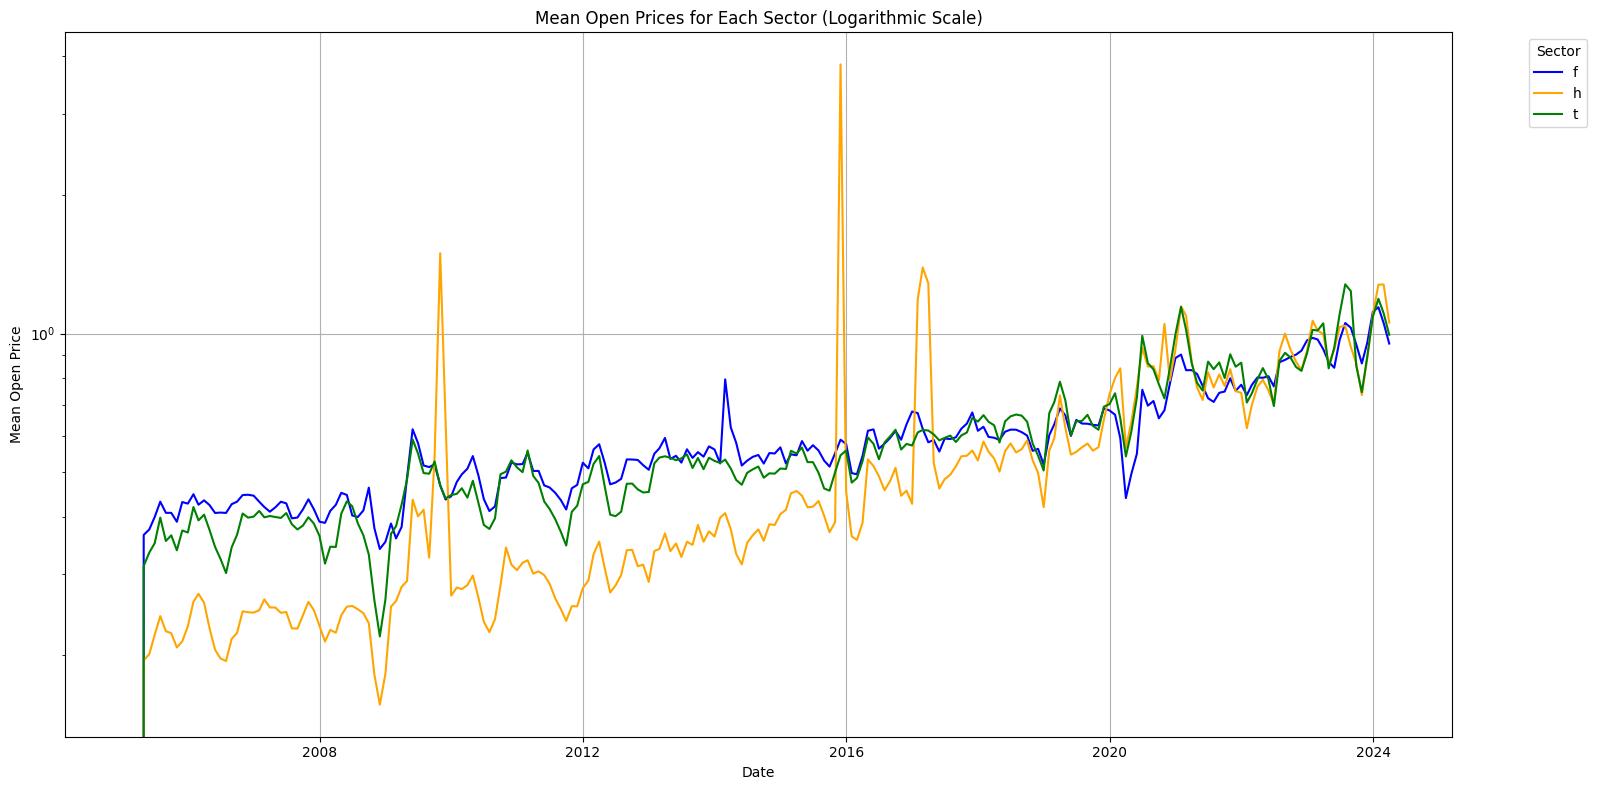

In [48]:
# Group data by sector
sector_groups = all_data.groupby('Sector')

# Define colors for each sector
colors = ['blue', 'orange', 'green']  # You can extend this list as needed

# Plot 'Open' prices for each sector with logarithmic scale
plt.figure(figsize=(16, 8))

for i, (sector, data) in enumerate(sector_groups):
    mean_open_prices = data.groupby('Date')['Open'].mean()
    plt.plot(mean_open_prices.index, mean_open_prices.values, label=sector, color=colors[i])

plt.yscale('log')  # Set y-axis scale to logarithmic
plt.title("Mean Open Prices for Each Sector (Logarithmic Scale)")
plt.xlabel('Date')
plt.ylabel('Mean Open Price')
plt.grid(True)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [60]:
#label encode sector and assign it to y and drop
timeseries_data = all_data.drop('Sector', axis=1)
all_data
timeseries_data



,Date,Ticker,Open,Sector
0,2005-01-31,AACI,0.000000,f
1,2005-02-28,AACI,0.000000,f
2,2005-03-31,AACI,0.000000,f
3,2005-04-30,AACI,0.000000,f
4,2005-05-31,AACI,0.000000,f
...,...,...,...,...
181561,2023-11-30,ZUO,1.048405,t
181562,2023-12-31,ZUO,1.150718,t
181563,2024-01-31,ZUO,1.269601,t
181564,2024-02-29,ZUO,0.833158,t


,Date,Ticker,Open
0,2005-01-31,AACI,0.000000
1,2005-02-28,AACI,0.000000
2,2005-03-31,AACI,0.000000
3,2005-04-30,AACI,0.000000
4,2005-05-31,AACI,0.000000
...,...,...,...
181561,2023-11-30,ZUO,1.048405
181562,2023-12-31,ZUO,1.150718
181563,2024-01-31,ZUO,1.269601
181564,2024-02-29,ZUO,0.833158


In [50]:
#%pip install tsfresh
import tsfresh


In [53]:
df_features = tsfresh.extract_features(timeseries_data, column_id='Ticker', column_sort='Date', 
                                       default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
df_features.columns

Feature Extraction: 100%|██████████| 30/30 [01:45<00:00,  3.53s/it]


Index(['Open__variance_larger_than_standard_deviation',
       'Open__has_duplicate_max', 'Open__has_duplicate_min',
       'Open__has_duplicate', 'Open__sum_values', 'Open__abs_energy',
       'Open__mean_abs_change', 'Open__mean_change',
       'Open__mean_second_derivative_central', 'Open__median',
       ...
       'Open__fourier_entropy__bins_5', 'Open__fourier_entropy__bins_10',
       'Open__fourier_entropy__bins_100',
       'Open__permutation_entropy__dimension_3__tau_1',
       'Open__permutation_entropy__dimension_4__tau_1',
       'Open__permutation_entropy__dimension_5__tau_1',
       'Open__permutation_entropy__dimension_6__tau_1',
       'Open__permutation_entropy__dimension_7__tau_1',
       'Open__query_similarity_count__query_None__threshold_0.0',
       'Open__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=783)

In [54]:
df_features.shape

(3001, 783)

In [55]:
df_features

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,1.0,1.0,237.091357,251.379356,0.093740,0.004623,-0.000024,1.048282,...,0.571431,0.959766,2.644841,1.744031,2.970987,4.117719,4.931195,5.306707,NaN,1.352405
AACI,0.0,0.0,1.0,1.0,26.364922,26.746199,0.006069,0.004529,0.000034,0.000000,...,0.099050,0.099050,0.248435,0.340912,0.465602,0.557121,0.607840,0.616247,NaN,1.038314
AACT,0.0,0.0,1.0,1.0,7.099224,7.199972,0.004484,0.004389,-0.000015,0.000000,...,0.099050,0.099050,0.099050,0.056151,0.056359,0.056569,0.056780,0.056992,NaN,1.014175
AADI,0.0,0.0,1.0,1.0,65.858257,70.655179,0.079195,0.004493,0.001399,0.000000,...,0.099050,0.185847,0.556229,0.904470,1.367809,1.706481,1.842079,1.887964,NaN,1.764074
AAMC,0.0,0.0,1.0,1.0,28.945540,54.823280,0.045521,0.003625,-0.001082,0.000000,...,0.099050,0.099050,0.218645,0.264151,0.350298,0.419780,0.489708,0.553924,NaN,2.361829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,0.0,0.0,1.0,1.0,7.777879,6.423704,0.010486,0.002881,-0.000341,0.000000,...,0.099050,0.099050,0.099050,0.162169,0.196916,0.197646,0.198381,0.199123,NaN,0.841855
ZVRA,0.0,0.0,1.0,1.0,103.596188,125.336457,0.126488,0.004428,-0.000892,0.000000,...,0.099050,0.148462,0.972657,1.215103,1.872192,2.401933,2.689902,2.792770,NaN,2.080898
ZVSA,0.0,0.0,1.0,1.0,13.516429,11.296830,0.026343,0.003467,0.001105,0.000000,...,0.087100,0.099050,0.325883,0.269264,0.396449,0.494023,0.558018,0.622408,NaN,1.056232
ZYME,0.0,0.0,1.0,1.0,85.190590,97.852292,0.070803,0.004384,-0.000794,0.000000,...,0.099050,0.148462,0.589019,0.960652,1.449316,1.870038,2.031477,2.102376,NaN,1.690951


In [61]:
df_features.shape
all_data.shape

(3001, 783)

(693231, 4)

In [62]:
# First, let's create a dictionary mapping tickers to sectors
ticker_sector_map = dict(zip(all_data['Ticker'], all_data['Sector']))

# Then, map the sectors to the index of df_features
df_features['Sector'] = df_features.index.map(ticker_sector_map)

# Displaying the updated df_features DataFrame
df_features

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7,Sector
A,0.0,0.0,1.0,1.0,237.091357,251.379356,0.093740,0.004623,-0.000024,1.048282,...,0.959766,2.644841,1.744031,2.970987,4.117719,4.931195,5.306707,NaN,1.352405,h
AACI,0.0,0.0,1.0,1.0,26.364922,26.746199,0.006069,0.004529,0.000034,0.000000,...,0.099050,0.248435,0.340912,0.465602,0.557121,0.607840,0.616247,NaN,1.038314,f
AACT,0.0,0.0,1.0,1.0,7.099224,7.199972,0.004484,0.004389,-0.000015,0.000000,...,0.099050,0.099050,0.056151,0.056359,0.056569,0.056780,0.056992,NaN,1.014175,f
AADI,0.0,0.0,1.0,1.0,65.858257,70.655179,0.079195,0.004493,0.001399,0.000000,...,0.185847,0.556229,0.904470,1.367809,1.706481,1.842079,1.887964,NaN,1.764074,h
AAMC,0.0,0.0,1.0,1.0,28.945540,54.823280,0.045521,0.003625,-0.001082,0.000000,...,0.099050,0.218645,0.264151,0.350298,0.419780,0.489708,0.553924,NaN,2.361829,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,0.0,0.0,1.0,1.0,7.777879,6.423704,0.010486,0.002881,-0.000341,0.000000,...,0.099050,0.099050,0.162169,0.196916,0.197646,0.198381,0.199123,NaN,0.841855,h
ZVRA,0.0,0.0,1.0,1.0,103.596188,125.336457,0.126488,0.004428,-0.000892,0.000000,...,0.148462,0.972657,1.215103,1.872192,2.401933,2.689902,2.792770,NaN,2.080898,h
ZVSA,0.0,0.0,1.0,1.0,13.516429,11.296830,0.026343,0.003467,0.001105,0.000000,...,0.099050,0.325883,0.269264,0.396449,0.494023,0.558018,0.622408,NaN,1.056232,h
ZYME,0.0,0.0,1.0,1.0,85.190590,97.852292,0.070803,0.004384,-0.000794,0.000000,...,0.148462,0.589019,0.960652,1.449316,1.870038,2.031477,2.102376,NaN,1.690951,h


In [63]:
#label encode sector and assign it to y and drop
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df_features['Sector'])
df_features.drop('Sector', axis=1, inplace=True)
df_features
y

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,1.0,1.0,237.091357,251.379356,0.093740,0.004623,-0.000024,1.048282,...,0.571431,0.959766,2.644841,1.744031,2.970987,4.117719,4.931195,5.306707,NaN,1.352405
AACI,0.0,0.0,1.0,1.0,26.364922,26.746199,0.006069,0.004529,0.000034,0.000000,...,0.099050,0.099050,0.248435,0.340912,0.465602,0.557121,0.607840,0.616247,NaN,1.038314
AACT,0.0,0.0,1.0,1.0,7.099224,7.199972,0.004484,0.004389,-0.000015,0.000000,...,0.099050,0.099050,0.099050,0.056151,0.056359,0.056569,0.056780,0.056992,NaN,1.014175
AADI,0.0,0.0,1.0,1.0,65.858257,70.655179,0.079195,0.004493,0.001399,0.000000,...,0.099050,0.185847,0.556229,0.904470,1.367809,1.706481,1.842079,1.887964,NaN,1.764074
AAMC,0.0,0.0,1.0,1.0,28.945540,54.823280,0.045521,0.003625,-0.001082,0.000000,...,0.099050,0.099050,0.218645,0.264151,0.350298,0.419780,0.489708,0.553924,NaN,2.361829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,0.0,0.0,1.0,1.0,7.777879,6.423704,0.010486,0.002881,-0.000341,0.000000,...,0.099050,0.099050,0.099050,0.162169,0.196916,0.197646,0.198381,0.199123,NaN,0.841855
ZVRA,0.0,0.0,1.0,1.0,103.596188,125.336457,0.126488,0.004428,-0.000892,0.000000,...,0.099050,0.148462,0.972657,1.215103,1.872192,2.401933,2.689902,2.792770,NaN,2.080898
ZVSA,0.0,0.0,1.0,1.0,13.516429,11.296830,0.026343,0.003467,0.001105,0.000000,...,0.087100,0.099050,0.325883,0.269264,0.396449,0.494023,0.558018,0.622408,NaN,1.056232
ZYME,0.0,0.0,1.0,1.0,85.190590,97.852292,0.070803,0.004384,-0.000794,0.000000,...,0.099050,0.148462,0.589019,0.960652,1.449316,1.870038,2.031477,2.102376,NaN,1.690951


array([1, 0, 0, ..., 1, 1, 1])

In [65]:
df_features.shape
all_data.shape
y.shape

(3001, 783)

(693231, 4)

(3001,)

In [67]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
impute(df_features)
features_filtered = select_features(df_features, y)
features_filtered

,Open__variance_larger_than_standard_deviation,Open__has_duplicate_max,Open__has_duplicate_min,Open__has_duplicate,Open__sum_values,Open__abs_energy,Open__mean_abs_change,Open__mean_change,Open__mean_second_derivative_central,Open__median,...,Open__fourier_entropy__bins_5,Open__fourier_entropy__bins_10,Open__fourier_entropy__bins_100,Open__permutation_entropy__dimension_3__tau_1,Open__permutation_entropy__dimension_4__tau_1,Open__permutation_entropy__dimension_5__tau_1,Open__permutation_entropy__dimension_6__tau_1,Open__permutation_entropy__dimension_7__tau_1,Open__query_similarity_count__query_None__threshold_0.0,Open__mean_n_absolute_max__number_of_maxima_7
A,0.0,0.0,1.0,1.0,237.091357,251.379356,0.093740,0.004623,-0.000024,1.048282,...,0.571431,0.959766,2.644841,1.744031,2.970987,4.117719,4.931195,5.306707,0.0,1.352405
AACI,0.0,0.0,1.0,1.0,26.364922,26.746199,0.006069,0.004529,0.000034,0.000000,...,0.099050,0.099050,0.248435,0.340912,0.465602,0.557121,0.607840,0.616247,0.0,1.038314
AACT,0.0,0.0,1.0,1.0,7.099224,7.199972,0.004484,0.004389,-0.000015,0.000000,...,0.099050,0.099050,0.099050,0.056151,0.056359,0.056569,0.056780,0.056992,0.0,1.014175
AADI,0.0,0.0,1.0,1.0,65.858257,70.655179,0.079195,0.004493,0.001399,0.000000,...,0.099050,0.185847,0.556229,0.904470,1.367809,1.706481,1.842079,1.887964,0.0,1.764074
AAMC,0.0,0.0,1.0,1.0,28.945540,54.823280,0.045521,0.003625,-0.001082,0.000000,...,0.099050,0.099050,0.218645,0.264151,0.350298,0.419780,0.489708,0.553924,0.0,2.361829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,0.0,0.0,1.0,1.0,7.777879,6.423704,0.010486,0.002881,-0.000341,0.000000,...,0.099050,0.099050,0.099050,0.162169,0.196916,0.197646,0.198381,0.199123,0.0,0.841855
ZVRA,0.0,0.0,1.0,1.0,103.596188,125.336457,0.126488,0.004428,-0.000892,0.000000,...,0.099050,0.148462,0.972657,1.215103,1.872192,2.401933,2.689902,2.792770,0.0,2.080898
ZVSA,0.0,0.0,1.0,1.0,13.516429,11.296830,0.026343,0.003467,0.001105,0.000000,...,0.087100,0.099050,0.325883,0.269264,0.396449,0.494023,0.558018,0.622408,0.0,1.056232
ZYME,0.0,0.0,1.0,1.0,85.190590,97.852292,0.070803,0.004384,-0.000794,0.000000,...,0.099050,0.148462,0.589019,0.960652,1.449316,1.870038,2.031477,2.102376,0.0,1.690951


,"Open__fft_aggregated__aggtype_""centroid""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","Open__fft_aggregated__aggtype_""skew""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","Open__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","Open__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,"Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","Open__fft_coefficient__attr_""real""__coeff_87","Open__fft_coefficient__attr_""real""__coeff_88","Open__fft_coefficient__attr_""imag""__coeff_47","Open__fft_coefficient__attr_""angle""__coeff_92",Open__quantile__q_0.9,"Open__fft_coefficient__attr_""real""__coeff_47","Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","Open__fft_coefficient__attr_""imag""__coeff_29","Open__fft_coefficient__attr_""imag""__coeff_93"
A,19.759415,0.004942,1.734191,0.003700,0.002799,0.008900,0.001225,0.003079,0.002512,0.011814,...,0.000287,-0.195366,0.627281,1.457623,-13.671973,1.209759,-1.882400,0.009171,1.602197,0.033194
AACI,22.780702,0.004392,1.512961,0.004392,0.009105,0.004392,0.003088,0.004392,0.004392,0.004408,...,0.000000,-0.568684,-0.185469,1.399416,132.807424,1.001009,0.165928,0.000000,1.880551,0.472712
AACT,30.118539,0.004405,1.204678,0.004405,0.007585,0.004405,0.002465,0.004405,0.004405,0.004406,...,0.000000,-0.989079,-0.927065,1.504950,-146.518677,0.000000,-0.647658,0.000000,-0.003684,-0.365504
AADI,29.382939,0.034611,1.050051,0.034611,0.016120,0.034611,0.004957,0.034611,0.044958,0.040863,...,0.000000,-1.673714,0.564419,-0.900969,79.201100,0.992308,-1.126806,0.005055,-2.993892,2.140708
AAMC,22.149835,0.031754,1.982792,0.031754,0.020082,0.031754,0.006077,0.031754,0.031754,0.033813,...,0.000000,0.287106,0.114091,0.201905,173.878123,0.000000,0.154652,0.000000,-1.808863,-0.215405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,28.011356,0.004085,1.315637,0.004085,0.007876,0.004085,0.002380,0.004085,0.004085,0.004186,...,0.000000,-0.127558,-0.083857,-0.518109,111.920738,0.000000,-0.457863,0.000000,1.293013,0.213633
ZVRA,33.345025,0.097433,0.881344,0.097433,0.023151,0.097433,0.006578,0.182145,0.437647,0.113413,...,0.000187,-3.866253,0.372865,0.401469,153.244854,1.194445,0.829757,0.006900,4.758100,-1.150066
ZVSA,36.845467,0.020464,0.786136,0.020464,0.009089,0.020464,0.002897,0.020464,0.020464,0.021146,...,0.000000,-0.447894,-0.004103,-0.519475,60.336976,0.000000,-1.910431,0.000000,-1.329519,1.546225
ZYME,23.142162,0.020689,1.520420,0.020689,0.014685,0.020689,0.004663,0.020689,0.049278,0.025683,...,0.000000,-1.206453,0.082865,-0.102524,91.656482,1.214383,-2.612960,0.004665,2.102706,0.721869


In [70]:
all_data

,Date,Ticker,Open,Sector
0,2005-01-31,AACI,0.000000,f
1,2005-02-28,AACI,0.000000,f
2,2005-03-31,AACI,0.000000,f
3,2005-04-30,AACI,0.000000,f
4,2005-05-31,AACI,0.000000,f
...,...,...,...,...
181561,2023-11-30,ZUO,1.048405,t
181562,2023-12-31,ZUO,1.150718,t
181563,2024-01-31,ZUO,1.269601,t
181564,2024-02-29,ZUO,0.833158,t


In [71]:
features_filtered
y

,"Open__fft_aggregated__aggtype_""centroid""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","Open__fft_aggregated__aggtype_""skew""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","Open__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","Open__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,"Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","Open__fft_coefficient__attr_""real""__coeff_87","Open__fft_coefficient__attr_""real""__coeff_88","Open__fft_coefficient__attr_""imag""__coeff_47","Open__fft_coefficient__attr_""angle""__coeff_92",Open__quantile__q_0.9,"Open__fft_coefficient__attr_""real""__coeff_47","Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","Open__fft_coefficient__attr_""imag""__coeff_29","Open__fft_coefficient__attr_""imag""__coeff_93"
A,19.759415,0.004942,1.734191,0.003700,0.002799,0.008900,0.001225,0.003079,0.002512,0.011814,...,0.000287,-0.195366,0.627281,1.457623,-13.671973,1.209759,-1.882400,0.009171,1.602197,0.033194
AACI,22.780702,0.004392,1.512961,0.004392,0.009105,0.004392,0.003088,0.004392,0.004392,0.004408,...,0.000000,-0.568684,-0.185469,1.399416,132.807424,1.001009,0.165928,0.000000,1.880551,0.472712
AACT,30.118539,0.004405,1.204678,0.004405,0.007585,0.004405,0.002465,0.004405,0.004405,0.004406,...,0.000000,-0.989079,-0.927065,1.504950,-146.518677,0.000000,-0.647658,0.000000,-0.003684,-0.365504
AADI,29.382939,0.034611,1.050051,0.034611,0.016120,0.034611,0.004957,0.034611,0.044958,0.040863,...,0.000000,-1.673714,0.564419,-0.900969,79.201100,0.992308,-1.126806,0.005055,-2.993892,2.140708
AAMC,22.149835,0.031754,1.982792,0.031754,0.020082,0.031754,0.006077,0.031754,0.031754,0.033813,...,0.000000,0.287106,0.114091,0.201905,173.878123,0.000000,0.154652,0.000000,-1.808863,-0.215405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,28.011356,0.004085,1.315637,0.004085,0.007876,0.004085,0.002380,0.004085,0.004085,0.004186,...,0.000000,-0.127558,-0.083857,-0.518109,111.920738,0.000000,-0.457863,0.000000,1.293013,0.213633
ZVRA,33.345025,0.097433,0.881344,0.097433,0.023151,0.097433,0.006578,0.182145,0.437647,0.113413,...,0.000187,-3.866253,0.372865,0.401469,153.244854,1.194445,0.829757,0.006900,4.758100,-1.150066
ZVSA,36.845467,0.020464,0.786136,0.020464,0.009089,0.020464,0.002897,0.020464,0.020464,0.021146,...,0.000000,-0.447894,-0.004103,-0.519475,60.336976,0.000000,-1.910431,0.000000,-1.329519,1.546225
ZYME,23.142162,0.020689,1.520420,0.020689,0.014685,0.020689,0.004663,0.020689,0.049278,0.025683,...,0.000000,-1.206453,0.082865,-0.102524,91.656482,1.214383,-2.612960,0.004665,2.102706,0.721869


array([1, 0, 0, ..., 1, 1, 1])

In [72]:
# First, let's create a dictionary mapping tickers to sectors
ticker_sector_map = dict(zip(all_data['Ticker'], all_data['Sector']))

# Then, map the sectors to the index of df_features
features_filtered['Sector'] = features_filtered.index.map(ticker_sector_map)

# Displaying the updated df_features DataFrame
features_filtered

,"Open__fft_aggregated__aggtype_""centroid""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","Open__fft_aggregated__aggtype_""skew""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","Open__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","Open__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,"Open__fft_coefficient__attr_""real""__coeff_87","Open__fft_coefficient__attr_""real""__coeff_88","Open__fft_coefficient__attr_""imag""__coeff_47","Open__fft_coefficient__attr_""angle""__coeff_92",Open__quantile__q_0.9,"Open__fft_coefficient__attr_""real""__coeff_47","Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","Open__fft_coefficient__attr_""imag""__coeff_29","Open__fft_coefficient__attr_""imag""__coeff_93",Sector
A,19.759415,0.004942,1.734191,0.003700,0.002799,0.008900,0.001225,0.003079,0.002512,0.011814,...,-0.195366,0.627281,1.457623,-13.671973,1.209759,-1.882400,0.009171,1.602197,0.033194,h
AACI,22.780702,0.004392,1.512961,0.004392,0.009105,0.004392,0.003088,0.004392,0.004392,0.004408,...,-0.568684,-0.185469,1.399416,132.807424,1.001009,0.165928,0.000000,1.880551,0.472712,f
AACT,30.118539,0.004405,1.204678,0.004405,0.007585,0.004405,0.002465,0.004405,0.004405,0.004406,...,-0.989079,-0.927065,1.504950,-146.518677,0.000000,-0.647658,0.000000,-0.003684,-0.365504,f
AADI,29.382939,0.034611,1.050051,0.034611,0.016120,0.034611,0.004957,0.034611,0.044958,0.040863,...,-1.673714,0.564419,-0.900969,79.201100,0.992308,-1.126806,0.005055,-2.993892,2.140708,h
AAMC,22.149835,0.031754,1.982792,0.031754,0.020082,0.031754,0.006077,0.031754,0.031754,0.033813,...,0.287106,0.114091,0.201905,173.878123,0.000000,0.154652,0.000000,-1.808863,-0.215405,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,28.011356,0.004085,1.315637,0.004085,0.007876,0.004085,0.002380,0.004085,0.004085,0.004186,...,-0.127558,-0.083857,-0.518109,111.920738,0.000000,-0.457863,0.000000,1.293013,0.213633,h
ZVRA,33.345025,0.097433,0.881344,0.097433,0.023151,0.097433,0.006578,0.182145,0.437647,0.113413,...,-3.866253,0.372865,0.401469,153.244854,1.194445,0.829757,0.006900,4.758100,-1.150066,h
ZVSA,36.845467,0.020464,0.786136,0.020464,0.009089,0.020464,0.002897,0.020464,0.020464,0.021146,...,-0.447894,-0.004103,-0.519475,60.336976,0.000000,-1.910431,0.000000,-1.329519,1.546225,h
ZYME,23.142162,0.020689,1.520420,0.020689,0.014685,0.020689,0.004663,0.020689,0.049278,0.025683,...,-1.206453,0.082865,-0.102524,91.656482,1.214383,-2.612960,0.004665,2.102706,0.721869,h


In [105]:
df = features_filtered.copy()

In [106]:
df["Sector"].unique()

array(['h', 'f', 't'], dtype=object)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.01 sec] [RSS: 3.36529] [loc=-6.715 scale=6.897]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 3.20136] [loc=-13.816 scale=7.101]


[distfit] >INFO> [pareto    ] [0.50 sec] [RSS: 3.17926] [loc=-85.866 scale=72.051]
[distfit] >INFO> [dweibull  ] [12.2 sec] [RSS: 2.04586] [loc=-6.856 scale=6.993]
[distfit] >INFO> [t         ] [22.2 sec] [RSS: 2.45104] [loc=0.004 scale=0.177]
[distfit] >INFO> [genextreme] [52.1 sec] [RSS: 2.62669] [loc=-6.222 scale=43.322]
[distfit] >INFO> [gamma     ] [17.9 sec] [RSS: 3.36512] [loc=-281.697 scale=0.173]
[distfit] >INFO> [lognorm   ] [20.5 sec] [RSS: 3.43748] [loc=-13.816 scale=0.000]
[distfit] >INFO> [beta      ] [32.6 sec] [RSS: 2.23874] [loc=-13.816 scale=28.651]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 3.32663] [loc=-13.816 scale=22.150]
[distfit] >INFO> [loggamma  ] [4.71 sec] [RSS: 3.27739] [loc=1.463 scale=0.812]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Dweibull(loc:-6.855981, scale:6.992572)


          name     score         loc      scale  \
0     dweibull  2.045858   -6.855981   6.992572   
1         beta  2.238737  -13.815511   28.65073   
2            t  2.451035    0.004061   0.177001   
3   genextreme  2.626694   -6.221954  43.321761   
4       pareto  3.179258  -85.866166  72.050656   
5        expon  3.201357  -13.815511   7.100569   
6     loggamma  3.277388    1.462846   0.811532   
7      uniform  3.326628  -13.815511  22.150382   
8        gamma  3.365118 -281.697057   0.173213   
9         norm  3.365289   -6.714941   6.897033   
10     lognorm  3.437483  -13.815511   0.000001   

                                        arg  \
0                     (12.834169985553377,)   
1   (0.16000684099241833, 1.70781661623687)   
2                     (0.3090752332582411,)   
3                      (-5.70492803167785,)   
4                      (11.09049238251386,)   
5                                        ()   
6                    (0.10353754788585254,)   
7          

<Figure size 800x600 with 0 Axes>

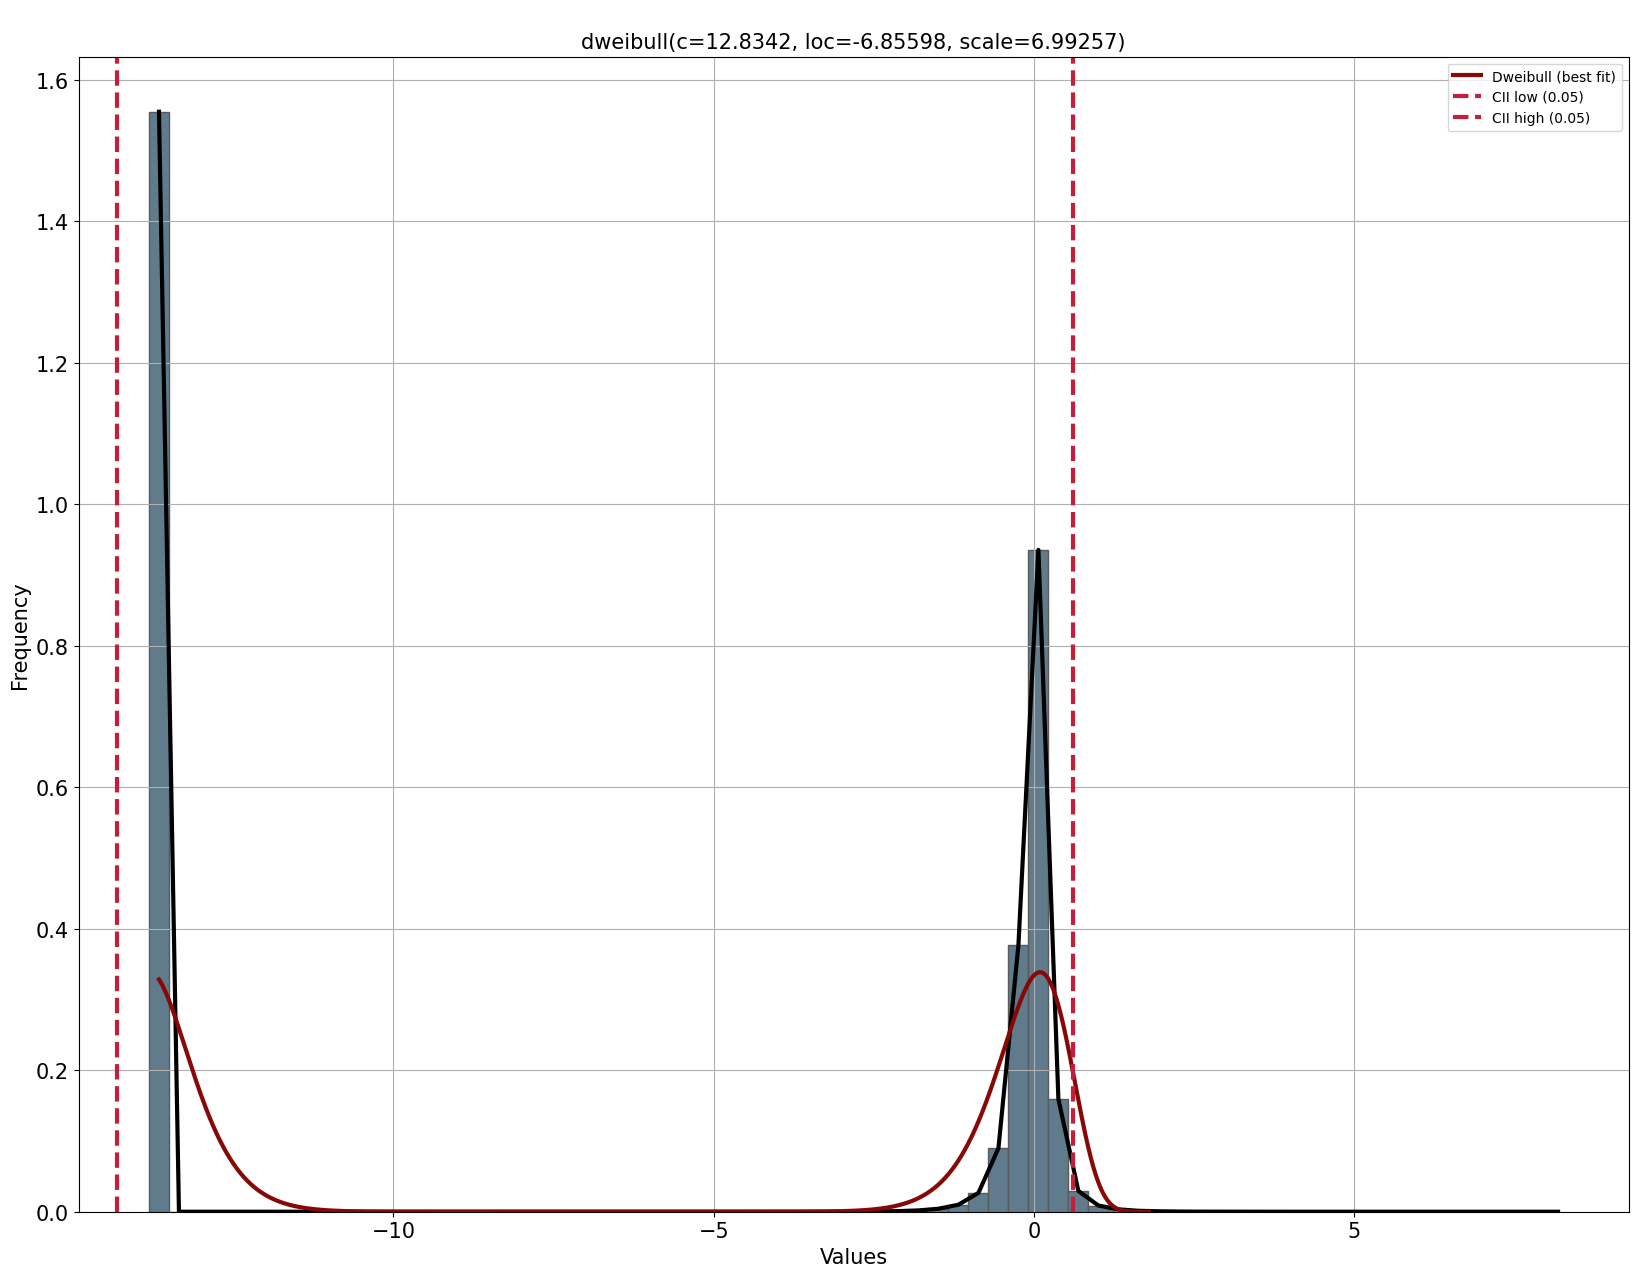

In [131]:
import distfit
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

def dist_check(df, variable):
    # Instantiate a distfit object
    dfit = distfit.distfit()
    
    # Apply logarithmic transformation to 'Open' values after adding a small constant
    df['Open_log'] = np.log(df[variable] + 1e-6)  # Add a small constant to avoid log(0)
    
    # Fit and transform the transformed 'Open' values
    results = dfit.fit_transform(df['Open_log'])
    
    # Print summary of the fit
    print(results['summary'])
    
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    dfit.plot(fontsize=15)
    plt.show()

# Usage example:
dist_check(all_data, 'Open')


In [78]:
#get last 3 columns
y = df.iloc[:, -1:]
X = df.iloc[:, :-1]
X
y

,"Open__fft_aggregated__aggtype_""centroid""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","Open__fft_aggregated__aggtype_""skew""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","Open__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","Open__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,"Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","Open__fft_coefficient__attr_""real""__coeff_87","Open__fft_coefficient__attr_""real""__coeff_88","Open__fft_coefficient__attr_""imag""__coeff_47","Open__fft_coefficient__attr_""angle""__coeff_92",Open__quantile__q_0.9,"Open__fft_coefficient__attr_""real""__coeff_47","Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","Open__fft_coefficient__attr_""imag""__coeff_29","Open__fft_coefficient__attr_""imag""__coeff_93"
A,19.759415,0.004942,1.734191,0.003700,0.002799,0.008900,0.001225,0.003079,0.002512,0.011814,...,0.000287,-0.195366,0.627281,1.457623,-13.671973,1.209759,-1.882400,0.009171,1.602197,0.033194
AACI,22.780702,0.004392,1.512961,0.004392,0.009105,0.004392,0.003088,0.004392,0.004392,0.004408,...,0.000000,-0.568684,-0.185469,1.399416,132.807424,1.001009,0.165928,0.000000,1.880551,0.472712
AACT,30.118539,0.004405,1.204678,0.004405,0.007585,0.004405,0.002465,0.004405,0.004405,0.004406,...,0.000000,-0.989079,-0.927065,1.504950,-146.518677,0.000000,-0.647658,0.000000,-0.003684,-0.365504
AADI,29.382939,0.034611,1.050051,0.034611,0.016120,0.034611,0.004957,0.034611,0.044958,0.040863,...,0.000000,-1.673714,0.564419,-0.900969,79.201100,0.992308,-1.126806,0.005055,-2.993892,2.140708
AAMC,22.149835,0.031754,1.982792,0.031754,0.020082,0.031754,0.006077,0.031754,0.031754,0.033813,...,0.000000,0.287106,0.114091,0.201905,173.878123,0.000000,0.154652,0.000000,-1.808863,-0.215405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,28.011356,0.004085,1.315637,0.004085,0.007876,0.004085,0.002380,0.004085,0.004085,0.004186,...,0.000000,-0.127558,-0.083857,-0.518109,111.920738,0.000000,-0.457863,0.000000,1.293013,0.213633
ZVRA,33.345025,0.097433,0.881344,0.097433,0.023151,0.097433,0.006578,0.182145,0.437647,0.113413,...,0.000187,-3.866253,0.372865,0.401469,153.244854,1.194445,0.829757,0.006900,4.758100,-1.150066
ZVSA,36.845467,0.020464,0.786136,0.020464,0.009089,0.020464,0.002897,0.020464,0.020464,0.021146,...,0.000000,-0.447894,-0.004103,-0.519475,60.336976,0.000000,-1.910431,0.000000,-1.329519,1.546225
ZYME,23.142162,0.020689,1.520420,0.020689,0.014685,0.020689,0.004663,0.020689,0.049278,0.025683,...,0.000000,-1.206453,0.082865,-0.102524,91.656482,1.214383,-2.612960,0.004665,2.102706,0.721869


,Sector
A,h
AACI,f
AACT,f
AADI,h
AAMC,f
...,...
ZURA,h
ZVRA,h
ZVSA,h
ZYME,h


In [79]:
#label encode sector and assign it to y and drop
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y['Sector'])
y

array([1, 0, 0, ..., 1, 1, 1])

In [80]:
X
y

,"Open__fft_aggregated__aggtype_""centroid""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","Open__fft_aggregated__aggtype_""skew""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","Open__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","Open__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,"Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","Open__fft_coefficient__attr_""real""__coeff_87","Open__fft_coefficient__attr_""real""__coeff_88","Open__fft_coefficient__attr_""imag""__coeff_47","Open__fft_coefficient__attr_""angle""__coeff_92",Open__quantile__q_0.9,"Open__fft_coefficient__attr_""real""__coeff_47","Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","Open__fft_coefficient__attr_""imag""__coeff_29","Open__fft_coefficient__attr_""imag""__coeff_93"
A,19.759415,0.004942,1.734191,0.003700,0.002799,0.008900,0.001225,0.003079,0.002512,0.011814,...,0.000287,-0.195366,0.627281,1.457623,-13.671973,1.209759,-1.882400,0.009171,1.602197,0.033194
AACI,22.780702,0.004392,1.512961,0.004392,0.009105,0.004392,0.003088,0.004392,0.004392,0.004408,...,0.000000,-0.568684,-0.185469,1.399416,132.807424,1.001009,0.165928,0.000000,1.880551,0.472712
AACT,30.118539,0.004405,1.204678,0.004405,0.007585,0.004405,0.002465,0.004405,0.004405,0.004406,...,0.000000,-0.989079,-0.927065,1.504950,-146.518677,0.000000,-0.647658,0.000000,-0.003684,-0.365504
AADI,29.382939,0.034611,1.050051,0.034611,0.016120,0.034611,0.004957,0.034611,0.044958,0.040863,...,0.000000,-1.673714,0.564419,-0.900969,79.201100,0.992308,-1.126806,0.005055,-2.993892,2.140708
AAMC,22.149835,0.031754,1.982792,0.031754,0.020082,0.031754,0.006077,0.031754,0.031754,0.033813,...,0.000000,0.287106,0.114091,0.201905,173.878123,0.000000,0.154652,0.000000,-1.808863,-0.215405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,28.011356,0.004085,1.315637,0.004085,0.007876,0.004085,0.002380,0.004085,0.004085,0.004186,...,0.000000,-0.127558,-0.083857,-0.518109,111.920738,0.000000,-0.457863,0.000000,1.293013,0.213633
ZVRA,33.345025,0.097433,0.881344,0.097433,0.023151,0.097433,0.006578,0.182145,0.437647,0.113413,...,0.000187,-3.866253,0.372865,0.401469,153.244854,1.194445,0.829757,0.006900,4.758100,-1.150066
ZVSA,36.845467,0.020464,0.786136,0.020464,0.009089,0.020464,0.002897,0.020464,0.020464,0.021146,...,0.000000,-0.447894,-0.004103,-0.519475,60.336976,0.000000,-1.910431,0.000000,-1.329519,1.546225
ZYME,23.142162,0.020689,1.520420,0.020689,0.014685,0.020689,0.004663,0.020689,0.049278,0.025683,...,0.000000,-1.206453,0.082865,-0.102524,91.656482,1.214383,-2.612960,0.004665,2.102706,0.721869


array([1, 0, 0, ..., 1, 1, 1])

In [81]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (3001, 619)
Shape of y: (3001,)


In [140]:
X_last = X.copy()
y_last = y.copy()

In [141]:
X_last
y_last

,"Open__fft_aggregated__aggtype_""centroid""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","Open__fft_aggregated__aggtype_""skew""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","Open__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","Open__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,"Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.4","Open__fft_coefficient__attr_""real""__coeff_87","Open__fft_coefficient__attr_""real""__coeff_88","Open__fft_coefficient__attr_""imag""__coeff_47","Open__fft_coefficient__attr_""angle""__coeff_92",Open__quantile__q_0.9,"Open__fft_coefficient__attr_""real""__coeff_47","Open__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","Open__fft_coefficient__attr_""imag""__coeff_29","Open__fft_coefficient__attr_""imag""__coeff_93"
A,19.759415,0.004942,1.734191,0.003700,0.002799,0.008900,0.001225,0.003079,0.002512,0.011814,...,0.000287,-0.195366,0.627281,1.457623,-13.671973,1.209759,-1.882400,0.009171,1.602197,0.033194
AACI,22.780702,0.004392,1.512961,0.004392,0.009105,0.004392,0.003088,0.004392,0.004392,0.004408,...,0.000000,-0.568684,-0.185469,1.399416,132.807424,1.001009,0.165928,0.000000,1.880551,0.472712
AACT,30.118539,0.004405,1.204678,0.004405,0.007585,0.004405,0.002465,0.004405,0.004405,0.004406,...,0.000000,-0.989079,-0.927065,1.504950,-146.518677,0.000000,-0.647658,0.000000,-0.003684,-0.365504
AADI,29.382939,0.034611,1.050051,0.034611,0.016120,0.034611,0.004957,0.034611,0.044958,0.040863,...,0.000000,-1.673714,0.564419,-0.900969,79.201100,0.992308,-1.126806,0.005055,-2.993892,2.140708
AAMC,22.149835,0.031754,1.982792,0.031754,0.020082,0.031754,0.006077,0.031754,0.031754,0.033813,...,0.000000,0.287106,0.114091,0.201905,173.878123,0.000000,0.154652,0.000000,-1.808863,-0.215405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZURA,28.011356,0.004085,1.315637,0.004085,0.007876,0.004085,0.002380,0.004085,0.004085,0.004186,...,0.000000,-0.127558,-0.083857,-0.518109,111.920738,0.000000,-0.457863,0.000000,1.293013,0.213633
ZVRA,33.345025,0.097433,0.881344,0.097433,0.023151,0.097433,0.006578,0.182145,0.437647,0.113413,...,0.000187,-3.866253,0.372865,0.401469,153.244854,1.194445,0.829757,0.006900,4.758100,-1.150066
ZVSA,36.845467,0.020464,0.786136,0.020464,0.009089,0.020464,0.002897,0.020464,0.020464,0.021146,...,0.000000,-0.447894,-0.004103,-0.519475,60.336976,0.000000,-1.910431,0.000000,-1.329519,1.546225
ZYME,23.142162,0.020689,1.520420,0.020689,0.014685,0.020689,0.004663,0.020689,0.049278,0.025683,...,0.000000,-1.206453,0.082865,-0.102524,91.656482,1.214383,-2.612960,0.004665,2.102706,0.721869


array([1, 0, 0, ..., 1, 1, 1])

In [142]:
#ndarray unique values
np.unique(y_last, return_counts=True)

(array([0, 1, 2]), array([ 998, 1217,  786], dtype=int64))

In [135]:
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# X_last, y_last = make_classification(random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe.fit(X_train, y_train)  # apply scaling on training data


# pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

0.6671105193075899

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_last, y_last, test_size=0.2)
selector = RFE(
    RandomForestClassifier(random_state=10))

selector.fit(X_train, y_train)

X_train_rfe=selector.transform(X_train)
X_test_rfe=selector.transform(X_test)

RFE(estimator=RandomForestClassifier(random_state=10))

In [144]:
selected_feat = X_train.columns[(selector.get_support())]
len(selected_feat)
selector.get_feature_names_out()
selector.estimator_.feature_importances_
selector.feature_names_in_
selector.ranking_

309

array(['Open__fft_aggregated__aggtype_"centroid"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
       'Open__fft_aggregated__aggtype_"skew"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
       'Open__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0',
       'Open__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
       'Open__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"',
       'Open__absolute_maximum', 'Open__maximum',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6',
       'Open__agg_linear_trend__a

array([0.01308033, 0.01554774, 0.00812105, 0.01110175, 0.01629791,
       0.00477131, 0.01059281, 0.01176587, 0.01041211, 0.00918296,
       0.00602842, 0.00528223, 0.00430761, 0.00515448, 0.00296667,
       0.00901913, 0.00367149, 0.00383521, 0.00380563, 0.00207021,
       0.00433897, 0.00903359, 0.00348607, 0.00237393, 0.0038762 ,
       0.00464219, 0.00499879, 0.00273219, 0.00276378, 0.00275092,
       0.0031093 , 0.00497388, 0.00776022, 0.00671205, 0.00364541,
       0.00458551, 0.00530875, 0.00338832, 0.00308014, 0.00262226,
       0.00274589, 0.00713026, 0.0035593 , 0.00198436, 0.00310798,
       0.00279938, 0.0027768 , 0.00186294, 0.00210034, 0.00667393,
       0.00223783, 0.00289981, 0.00350892, 0.00275141, 0.00217311,
       0.00184349, 0.00229035, 0.00199659, 0.0027488 , 0.00231665,
       0.00268065, 0.00309948, 0.00353026, 0.00288493, 0.00418166,
       0.00243884, 0.00580456, 0.00695821, 0.00593779, 0.00235659,
       0.00480075, 0.00424019, 0.0019658 , 0.00180488, 0.00253

array(['Open__fft_aggregated__aggtype_"centroid"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
       'Open__fft_aggregated__aggtype_"skew"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
       'Open__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.0',
       'Open__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.6',
       'Open__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.4',
       'Open__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"max"',
       'Open__absolute_maximum', 'Open__maximum',
       'Open__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.6',
       'Open__agg_linear_trend__a

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,  81,   1,   1,   1,   1,  44,  71, 130,   1,  86,   1,
         1,   1,  74,   1, 171,   1,  60, 169,  93,   1, 126, 212,  23,
        99,   7,   1,   1,  10,   1,   1,  61,  28,  52,   1,  89, 170,
         1,   1, 102, 129, 138,  91,   1,   1,   1,   1, 117, 139,   1,
         1,   1, 114,   5, 149, 133, 100,   1, 162, 132,  68,  95,   1,
        75,  37, 125, 101, 141,  49,  27,   1,  79,  40,   1,   1,  69,
        97, 296,   1,  46, 298,   1, 166,  13,  43, 116, 120,  25,   1,
       159,  20, 163,  87,   1, 103,   1, 140, 155,  45,  65,   1, 153,
         1,  16,   1,   1, 173, 151,   1,   1,   1,  90,  41,   1,   1,
        78, 112, 199,   1,  82, 127,   1,   1, 234,   1, 263,  80,   1,
       276,   1,   1, 255, 291,   1,  92, 246, 280,   1,   1, 293, 165,
       272, 278, 147,   1,   1, 215, 284,   1, 136,   1,   1, 28

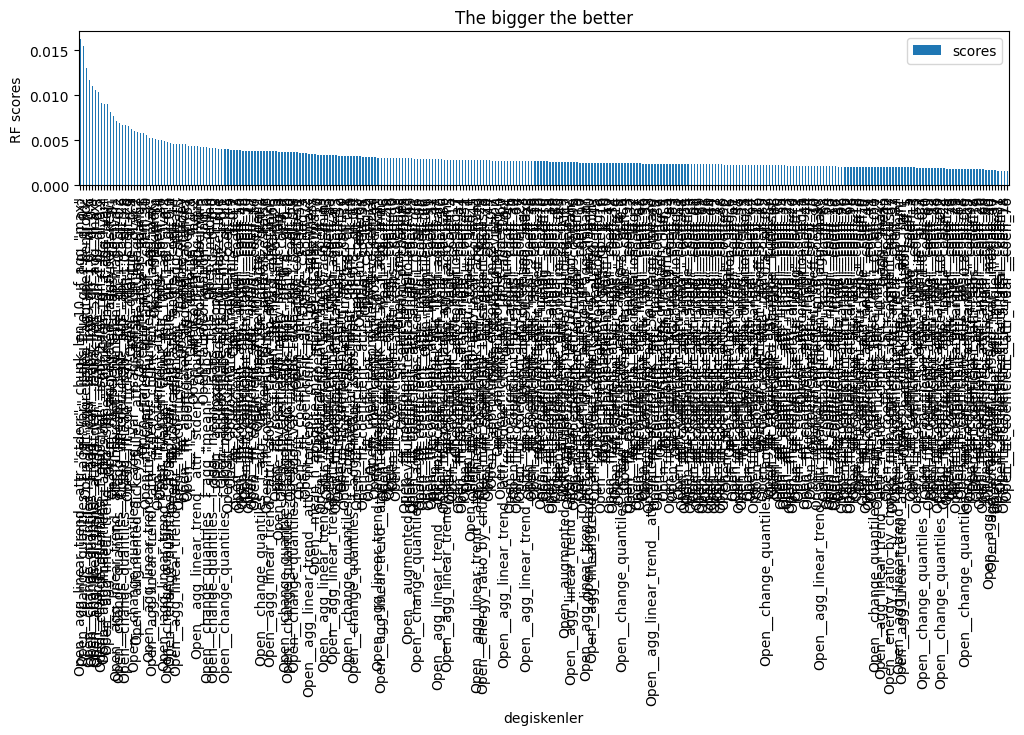

In [145]:
results = pd.DataFrame(data= selector.estimator_.feature_importances_, index=selector.get_feature_names_out(), columns=['scores'])
f, ax = plt.subplots(figsize=(12,2), nrows=1, ncols=1)
results.sort_values(by='scores', ascending=False).plot.bar(figsize=(12,2), ax=ax)
ax.set_xlabel('degiskenler')
ax.set_ylabel('RF scores')
ax.set_title('The bigger the better');

In [148]:
results

,scores
"Open__fft_aggregated__aggtype_""centroid""",0.013080
"Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2",0.015548
"Open__fft_aggregated__aggtype_""skew""",0.008121
"Open__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4",0.011102
"Open__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""",0.016298
...,...
"Open__fft_coefficient__attr_""imag""__coeff_47",0.003866
"Open__fft_coefficient__attr_""angle""__coeff_92",0.002037
Open__quantile__q_0.9,0.006260
"Open__fft_coefficient__attr_""real""__coeff_47",0.002315


In [155]:
results.reset_index(inplace=True)
results

,index,scores
0,"Open__fft_aggregated__aggtype_""centroid""",0.013080
1,"Open__change_quantiles__f_agg_""var""__isabs_Tru...",0.015548
2,"Open__fft_aggregated__aggtype_""skew""",0.008121
3,"Open__change_quantiles__f_agg_""var""__isabs_Tru...",0.011102
4,"Open__agg_linear_trend__attr_""stderr""__chunk_l...",0.016298
...,...,...
304,"Open__fft_coefficient__attr_""imag""__coeff_47",0.003866
305,"Open__fft_coefficient__attr_""angle""__coeff_92",0.002037
306,Open__quantile__q_0.9,0.006260
307,"Open__fft_coefficient__attr_""real""__coeff_47",0.002315


In [177]:
#get only the columns exist on results' index column in X_last
X_last = X_last[results['index']]
X_last.shape

(3001, 309)

In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_last, y_last, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2']  # Regularization penalty (L1 or L2)
}

# Initialize logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Perform grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Train the model with best hyperparameters
best_log_reg = grid_search.best_estimator_

# Perform cross-validation with the best model
cv_scores = cross_val_score(best_log_reg, X_train_scaled, y_train, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Evaluate the model on the test set
test_accuracy = best_log_reg.score(X_test_scaled, y_test)
print("Test accuracy:", test_accuracy)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

Best hyperparameters: {'C': 10, 'penalty': 'l2'}
Cross-validation scores: [0.7625     0.69166667 0.70833333 0.6625     0.69166667 0.7125
 0.7        0.70416667 0.68333333 0.70416667]
Mean accuracy: 0.7020833333333334
Test accuracy: 0.697171381031614


<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 36.72222222222221, 'Predicted labels')

Text(70.72222222222221, 0.5, 'True labels')

Text(0.5, 1.0, 'Confusion Matrix')

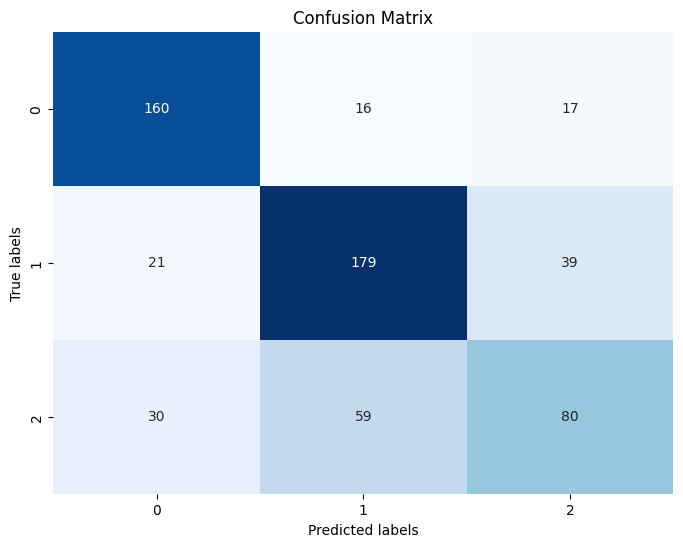

In [179]:
# Create confusion matrix
y_pred = best_log_reg.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [181]:
from onnxmltools import convert_sklearn
from onnxmltools.utils import save_model
from onnxmltools.convert.common.data_types import FloatTensorType
# Save the best logistic regression model using ONNX
initial_type = [('float_input', FloatTensorType([None, X_train_scaled.shape[1]]))]
onnx_model = convert_sklearn(best_log_reg, initial_types=initial_type, target_opset=12)
onnx_model_path = 'best_logistic_regression.onnx'
save_model(onnx_model, onnx_model_path)
print("Best logistic regression model saved successfully to:", onnx_model_path)

Best logistic regression model saved successfully to: best_logistic_regression.onnx


In [85]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split

# # Assuming X contains your features and y contains your target variable
# # Convert one-hot encoded y to 1D array if needed
# # y_last = y_last.values.ravel()

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_last, y_last, test_size=0.2)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Define hyperparameters to tune
# param_grid = {
#     'hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],  # Number of neurons in each hidden layer
#     'activation': ['relu', 'tanh'],  # Activation function
#     'alpha': [0.0001, 0.001, 0.01],  # L2 regularization parameter
# }

# # Initialize MLP classifier
# mlp_clf = MLPClassifier(max_iter=1000)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(mlp_clf, param_grid, cv=10, scoring='accuracy')
# grid_search.fit(X_train_scaled, y_train)

# # Print best hyperparameters
# print("Best hyperparameters:", grid_search.best_params_)

# # Train the model with best hyperparameters
# best_mlp_clf = grid_search.best_estimator_

# # Perform cross-validation with the best model
# cv_scores = cross_val_score(best_mlp_clf, X_train_scaled, y_train, cv=10)
# print("Cross-validation scores:", cv_scores)
# print("Mean accuracy:", cv_scores.mean())

# # Evaluate the model on the test set
# test_accuracy = best_mlp_clf.score(X_test_scaled, y_test)
# print("Test accuracy:", test_accuracy)


GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=1000),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (50, 50),
                                                (50, 100, 50)]},
             scoring='accuracy')

Best hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,)}
Cross-validation scores: [0.70416667 0.6875     0.64166667 0.74166667 0.7        0.7125
 0.6625     0.67083333 0.6625     0.72083333]
Mean accuracy: 0.6904166666666667
Test accuracy: 0.6888519134775375


In [157]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_last, y_last, test_size=0.2)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model with sparse categorical cross-entropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print("Test accuracy:", test_accuracy)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3631 - loss: 1.7508 - val_accuracy: 0.6375 - val_loss: 1.1211
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5030 - loss: 1.2794 - val_accuracy: 0.6896 - val_loss: 1.0542
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5780 - loss: 1.1652 - val_accuracy: 0.6938 - val_loss: 1.0096
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5822 - loss: 1.0858 - val_accuracy: 0.6917 - val_loss: 0.9818
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6076 - loss: 1.0712 - val_accuracy: 0.7000 - val_loss: 0.9560
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6441 - loss: 0.9772 - val_accuracy: 0.6958 - val_loss: 0.9419
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6746 - loss: 0.9545 - val_accuracy: 0.7042 - val_loss: 0.9223
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6600 - loss: 0.9491 - val_accuracy: 0.6958 - val_loss:

In [158]:
#confusion matrix 
from sklearn.metrics import confusion_matrix

# Predict the classes for the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
[[178  21  26]
 [ 18 176  39]
 [ 22  50  71]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 800x600 with 0 Axes>

<Axes: >

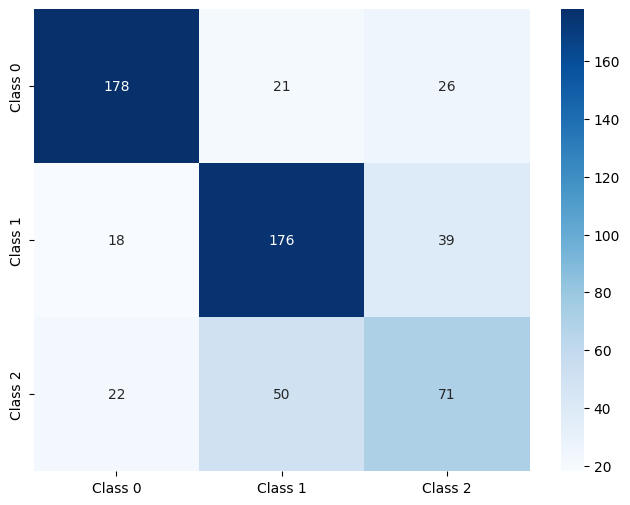

In [159]:

# Predict the classes for the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])


In [174]:
# Specify the file path where you want to save the model
model_path = 'my_model.h5'

# Save the model
model.save(model_path)

print("Model saved successfully to:", model_path)
 

[distfit] >WARNING> You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Model saved successfully to: my_model.h5


In [176]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model("my_model.h5")

[distfit] >WARNING> Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [162]:
real_estate = pd.read_csv('data/stock_sectors/real-estate.csv')

In [165]:
# Extract ticker symbols from real_estate data
ticker_list = real_estate['Symbol'].tolist()

# Download stock data for the tickers starting from 2005-01-01
data = yf.download(ticker_list, start='2005-01-01') 

# Calculate monthly percentage change in opening prices
data_real_estate = data["Open"].resample('ME').last().pct_change() + 1

# Define a function to get rolling returns over a specified window size
def get_rolling_ret(data, n): 
    return data.rolling(n).apply(np.prod)

# Calculate 3-month rolling returns
data_real_estate = get_rolling_ret(data_real_estate, 3).fillna(0)

# Reset index and melt the data for easier analysis
data_real_estate = data_real_estate.reset_index()
data_real_estate = data_real_estate.melt(id_vars="Date", var_name="Ticker", value_name="Open")

# Fill any NaN values with 0 and add a Sector column with a default value "f"
data_real_estate.fillna(0, inplace=True)

[**********************98%%********************* ]  257 of 261 completed[distfit] >WARNING> Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************99%%**********************]  258 of 261 completed[distfit] >WARNING> Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%%**********************]  261 of 261 completed


In [166]:
data_real_estate

,Date,Ticker,Open
0,2005-01-31,AAT,0.000000
1,2005-02-28,AAT,0.000000
2,2005-03-31,AAT,0.000000
3,2005-04-30,AAT,0.000000
4,2005-05-31,AAT,0.000000
...,...,...,...
60286,2023-11-30,XIN,0.961938
60287,2023-12-31,XIN,0.961673
60288,2024-01-31,XIN,0.992481
60289,2024-02-29,XIN,0.956835


In [168]:
# Get random 10 symbols
random_symbols = data_real_estate['Ticker'].sample(n=10, random_state=42)

# Filter the DataFrame to get rows corresponding to the random symbols
random_rows = data_real_estate[data_real_estate['Ticker'].isin(random_symbols)]

random_rows


,Date,Ticker,Open
1155,2005-01-31,AEI,0.000000
1156,2005-02-28,AEI,0.000000
1157,2005-03-31,AEI,0.000000
1158,2005-04-30,AEI,0.000000
1159,2005-05-31,AEI,0.000000
...,...,...,...
58207,2023-11-30,VTMX,0.937631
58208,2023-12-31,VTMX,1.192204
58209,2024-01-31,VTMX,1.216987
58210,2024-02-29,VTMX,0.980716


+ Yapılan işlemler pipeline ile tekrar yazılıp, real estate rastgele alınmış 10 şirket üzerinde aynı feature engineering uygulanacak.
+ Kaydedilen logistic regression ya da artificial neural network üzerinde model class'ı tahmin edilecek.
+ 3 class üzerinden probability yüzdelerine bakılıp benzerlik analizi yapılabilecektir. 